# How to use a linear regression model to predict the average Total alcohol consumption per capita (SH_ALC_PCAP_LI) using BigQuery ML

###### Copyright
**Notebook Author:** [Paul Kamau](https://paulkamau.com)<br>
**Project Type:** BQML Linear Reg<br>
**Date created:** 2023/01/23<br>
**Training Dataset** This project uses the public dataset [`World Bank Health`](https://pantheon.corp.google.com/marketplace/product/the-world-bank/global-health?project=paulkamau) has 4 Tables with different data tables.


### Summary

This project used a linear regression model in BigQuery ML to to predict the average Total alcohol consumption per capita (SH.ALC.PCAP.LI) based on the WorldBank Health International Data.

## Objective
1. Create a linear regression model
1. Evaluate the linear regression model
1. Make the alcohol consumption predictions using the linear regression model.

## steps
1. Create the dataset and dataset table
1. Use the SELECT statement to examine the data
1. Use the CREATE VIEW statement to compile your training data
1. Use the CREATE MODEL statement to create your linear regression model.
1. Use the ML.EVALUATE function to evaluate the model data
1. Use the ML.PREDICT function to predict the penguin weight for a given set of data
1. Use the ML.EXPLAIN_PREDICT function to explain prediction results with explainable AI Methods.
1. Use the ML.GLOBAL_EXPLAIN function to know which features are the most important to determine the weight.




## Prepare the Envrionment with Package Installs
1. Install the following packages required to execute this notebook.
1. install the workbench notebook product dependencies
1. Automatically restart kernel after installs

### Import AI Platform and ML libraries

In [48]:
import os
import sys

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform {USER_FLAG} -q google-cloud-bigquery db-dtypes

#### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [49]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Prepare the notebook to run in colab.

In [1]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.
import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = "google.colab" in sys.modules
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

#### Import the Google Cloud SDK packages

In [2]:
import google.cloud.aiplatform as vertex_ai
import pandas as pd
import matplotlib.pyplot as plt
import json

from typing import Union  # This module provides runtime support for type hints
from google.cloud import bigquery
from sklearn import metrics
from google.api import httpbody_pb2

print("All imports complete")

All imports complete


#### GCP & BQML Variables

In [3]:
# Project variables
#
# These are the project variable used in this ML Model:
#

PROJECT_ID = "" # @param {type:"string"}
BQML_MODEL_TYPE = "LINEAR_REG" #@param ["LINEAR_REG", "LOGISTIC_REG","KMEANS","PCA","MATRIX_FACTORIZATION","AUTOENCODER","AUTOML_REGRESSOR", "AUTOML_CLASSIFIER","BOOSTED_TREE_CLASSIFIER","BOOSTED_TREE_REGRESSOR","RANDOM_FOREST_CLASSIFIER","RANDOM_FOREST_REGRESSOR", "DNN_CLASSIFIER","DNN_REGRESSOR","DNN_LINEAR_COMBINED_CLASSIFIER", "DNN_LINEAR_COMBINED_REGRESSOR","ARIMA_PLUS","TENSORFLOW"]

BQML_MODEL_NAME = "bqml_linear_reg_worldbank_health_alcohol_consump_predict_model"
BQML_JOB_DISPLAY_NAME = BQML_MODEL_NAME + "_job"
BQML_ENDPOINT_NAME = BQML_MODEL_NAME + "_endpoint"
BQML_DEPLOYMENT_NAME = BQML_MODEL_NAME + "_deployment"

# datasets
BQ_DATASET_NAME = BQML_MODEL_NAME + "_dataset"
BQ_PUBLIC_DATASET = "paulkamau.WorldBank_Health.alcohol_consumption_avg"
BQ_DATASET_VIEW_TABLE= f"{BQ_DATASET_NAME}.input_view"

# bucket details
BUCKET_NAME = "bigquery_ml_tutorials"
BUCKET_URI = f"gs://{BUCKET_NAME}/{BQML_MODEL_TYPE}/{BQML_MODEL_NAME}"
OUTPUTBUCKET = f"gs://bqml_datasets_predictions/{BQML_MODEL_TYPE}/"

# Region
REGION = "us-central1" #@param ["us-central1", "europe-west4", "asia-east1"]

print("All variables set")

All variables set


#### Set the Service account automatically from gcloud

In [4]:
# Get your service account from gcloud
if not IS_COLAB:
    shell_output = !gcloud auth list 2>/dev/null
    SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

else:  # IS_COLAB:
    shell_output = ! gcloud projects describe  $PROJECT_ID
    project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
    SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

print("Service Account:", SERVICE_ACCOUNT)

Service Account: 993987777814-compute@developer.gserviceaccount.com


#### Initialize Vertex AI and BigQuery SDKs for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [5]:
vertex_ai.init(project=PROJECT_ID, location=REGION)

print("vertex initialized")

vertex initialized


Create the BigQuery client.

In [6]:
bq_client = bigquery.Client(project=PROJECT_ID)

print("BQ client initialized")

BQ client initialized


Use a helper function for sending queries to BigQuery.

In [7]:
# Wrapper to use BigQuery client to run query/job, return job ID or result as DF
def run_bq_query(sql: str) -> Union[str, pd.DataFrame]:
    """
    Input: SQL query, as a string, to execute in BigQuery
    Returns the query results as a pandas DataFrame, or error, if any
    """

    # Try dry run before executing query to catch any errors
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    bq_client.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    client_result = bq_client.query(sql, job_config=job_config)

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")
    return df

print("BQ wrapper set")

BQ wrapper set


## **Dataset**:

The dataset [`world_bank_health_population`](https://cloud.google.com/bigquery?sq=1057666841514:3bb229234d7f4b379098581f0101e923&_ga=2.81369303.-1379782407.1673021064&project=paulkamau&ws=!1m9!1m3!3m2!1sbigquery-public-data!2sworld_bank_health_population!1m4!4m3!1sbigquery-public-data!2sworld_bank_health_population!3scountry_series_definitions) combines key health statistics from a variety of sources to provide a look at global health and population trends. It includes information on nutrition, reproductive health, education, immunization, and diseases from over 200 countries.

Multiple tables have been used to compile the data. The data was flattened to create a single working set:

- Country series definitions
- Country summary
- Health nutrition population
- International debt
- Series summary
- Series times


### Step 1: Create Your Dataset
BigQuery organizes data tables into units called datasets. These datasets are scoped to your GCP project. Datasets are:

[Dataset SDK Reference](https://cloud.google.com/bigquery/docs/datasets-intro)

In [9]:
# check if Dataset exists.
sql_list_dataset_exists = f"""SELECT count (*) FROM INFORMATION_SCHEMA.SCHEMATA WHERE schema_name = '{BQ_DATASET_NAME}'"""

# Display the sql statement
print(sql_list_dataset_exists)

# execute the sql statement
run_bq_query(sql_list_dataset_exists)

if sql_list_dataset_exists:
    print("Dataset exists")
    print(f'Review the Dataset in the Console:\nhttps://console.cloud.google.com/bigquery?page=dataset&p={PROJECT_ID}&d={BQ_DATASET_NAME}&project={PROJECT_ID}')
else:
  print("dataset doesn't exist")


SELECT count (*) FROM INFORMATION_SCHEMA.SCHEMATA WHERE schema_name = 'bqml_linear_reg_worldbank_health_alcohol_consump_predict_model_dataset'
Finished job_id: 0a0ffae7-5207-4890-8e6a-9a1b734a7226
Dataset exists
Review the Dataset in the Console:
https://console.cloud.google.com/bigquery?page=dataset&p=paulkamau&d=bqml_linear_reg_worldbank_health_alcohol_consump_predict_model_dataset&project=paulkamau


In [10]:
sql_create_dataset = f"""CREATE SCHEMA IF NOT EXISTS {BQ_DATASET_NAME}"""

print(sql_create_dataset)

run_bq_query(sql_create_dataset)

print(f'Review the Dataset in the Console:\nhttps://console.cloud.google.com/bigquery?page=dataset&p={PROJECT_ID}&d={BQ_DATASET_NAME}&project={PROJECT_ID}')

CREATE SCHEMA IF NOT EXISTS bqml_linear_reg_worldbank_health_alcohol_consump_predict_model_dataset
Finished job_id: a1b7b175-3bd3-4b2f-80d6-c234fbddf049
Review the Dataset in the Console:
https://console.cloud.google.com/bigquery?page=dataset&p=paulkamau&d=bqml_linear_reg_worldbank_health_alcohol_consump_predict_model_dataset&project=paulkamau


Inspect data that has been pre-processed from  [`WorldBank Health`](https://cloud.google.com/bigquery?sq=1057666841514:f29282e50d984f96a6fa3395aa080abf&_ga=2.187413480.-1379782407.1673021064&project=paulkamau&ws=!1m4!1m3!3m2!1s1057666841514!2schicago_crime)

The data view results show that the **``SH_ALC_PCAP_LI``** column in the alcohol_consumption_avg table has linear values: "yes" or "no"



In [11]:
sql_inspect_full_feature_dataset = f"""
SELECT *
FROM
`{BQ_PUBLIC_DATASET}`
LIMIT
 10;
"""

sql_inspect_record_count_dataset = f"""
SELECT count(*)
FROM
 `{BQ_PUBLIC_DATASET}`
"""

# Display the sql statement
print(sql_inspect_full_feature_dataset)
print(run_bq_query(sql_inspect_record_count_dataset))
run_bq_query(sql_inspect_full_feature_dataset)



SELECT *
FROM
`paulkamau.WorldBank_Health.alcohol_consumption_avg`
LIMIT
 10;

Finished job_id: e7abd084-a31c-4583-9c3f-138f189b46b7
   f0_
0  172
Finished job_id: e938d3d8-7032-42fa-8f04-b95960a2f4ec


,row_id,short_name,currency_unit,income_group,national_accounts_base_year,sna_price_valuation,system_of_national_accounts,system_of_trade,government_accounting_concept,country_name,country_code,SH_ALC_PCAP_LI,SH_PRV_SMOK_FE,SH_STA_DIAB_ZS,SH_PRV_SMOK_MA,SH_PRV_SMOK,SH_ALC_PCAP_FE_LI
0,34,Central African Republic,Central African CFA franc,Low income,2005,Value added at basic prices (VAB),Country uses the 1993 System of National Accou...,General trade system,Budgetary central government,Central African Republic,CAF,3.218,NaN,2.75,NaN,NaN,1.316
1,172,Zimbabwe,Zimbabwean Dollar,Lower middle income,2012,Value added at basic prices (VAB),Country uses the 2008 System of National Accou...,General trade system,Budgetary central government,Zimbabwe,ZWE,3.750,1.666667,2.95,28.366667,15.016667,1.322
2,6,Antigua and Barbuda,East Caribbean dollar,High income,2006,Value added at basic prices (VAB),Country uses the 2008 System of National Accou...,General trade system,Budgetary central government,Antigua and Barbuda,ATG,5.674,NaN,10.10,NaN,NaN,2.572
3,14,Bahrain,Bahraini dinar,High income,2010,Value added at producer prices (VAP),Country uses the 1993 System of National Accou...,General trade system,Budgetary central government,Bahrain,BHR,1.516,9.416667,15.50,35.133333,21.516667,0.452
4,37,Colombia,Colombian peso,Upper middle income,2015,Value added at basic prices (VAB),Country uses the 2008 System of National Accou...,Special trade system,Consolidated central government,Colombia,COL,5.510,5.050000,6.30,10.533333,8.216667,2.274
5,106,Morocco,Moroccan dirham,Lower middle income,2007,Value added at basic prices (VAB),Country uses the 2008 System of National Accou...,Special trade system,Budgetary central government,Morocco,MAR,0.852,1.116667,4.65,32.616667,14.016667,0.230
6,112,New Caledonia,CFP franc,High income,2017,Value added at basic prices (VAB),Country uses the 2008 System of National Accou...,General trade system,None,New Caledonia,NCL,NaN,NaN,14.50,NaN,NaN,NaN
7,2,Albania,Albanian lek,Upper middle income,Original chained constant price data are resca...,Value added at basic prices (VAB),Country uses the 2008 System of National Accou...,Special trade system,Consolidated central government,Albania,ALB,7.164,8.683333,2.75,52.200000,25.266667,2.730
8,40,Costa Rica,Costa Rican colon,Upper middle income,Original chained constant price data are resca...,Value added at basic prices (VAB),Country uses the 2008 System of National Accou...,Special trade system,Consolidated central government,Costa Rica,CRI,5.080,5.400000,9.20,14.416667,11.733333,1.878
9,48,Egypt,Egyptian pound,Lower middle income,2016/17,Value added at basic prices (VAB),Country uses the 1993 System of National Accou...,General trade system,Budgetary central government,"Egypt, Arab Rep.",EGY,0.332,0.516667,14.30,35.166667,21.266667,0.091


### Dataset column variables

In [12]:
## Dataset variables
MODEL_FEATURE_COLUMNS = "short_name, currency_unit, income_group, national_accounts_base_year, sna_price_valuation, system_of_national_accounts, system_of_trade, government_accounting_concept, country_name, country_code, SH_ALC_PCAP_LI, SH_PRV_SMOK_FE, SH_STA_DIAB_ZS, SH_PRV_SMOK_MA, SH_PRV_SMOK, SH_ALC_PCAP_FE_LI"
MODEL_INPUT_COLUMNS = "SH_ALC_PCAP_LI,short_name, currency_unit, income_group, national_accounts_base_year,system_of_trade, government_accounting_concept, country_name, country_code,SH_PRV_SMOK_FE, SH_STA_DIAB_ZS, SH_PRV_SMOK_MA, SH_PRV_SMOK, SH_ALC_PCAP_FE_LI"
MODEL_DROPPED_COLUMNS = "sna_price_valuation,system_of_national_accounts"
MODEL_LABEL_PREDICTION = 'SH_ALC_PCAP_LI'
print('All dataset column selections updated')

All dataset column selections updated


#### These will be our input columns and data for the model we're building

In [13]:
sql_inspect_dataset = f"""
SELECT
 {MODEL_INPUT_COLUMNS},
FROM
 `{BQ_PUBLIC_DATASET}`
LIMIT
 10;
"""

# Display the sql statement
print(sql_inspect_dataset)

# Run the query
run_bq_query(sql_inspect_dataset)


SELECT
 SH_ALC_PCAP_LI,short_name, currency_unit, income_group, national_accounts_base_year,system_of_trade, government_accounting_concept, country_name, country_code,SH_PRV_SMOK_FE, SH_STA_DIAB_ZS, SH_PRV_SMOK_MA, SH_PRV_SMOK, SH_ALC_PCAP_FE_LI,
FROM
 `paulkamau.WorldBank_Health.alcohol_consumption_avg`
LIMIT
 10;

Finished job_id: de13380d-3921-4380-8c88-8459dc9e23f2


,SH_ALC_PCAP_LI,short_name,currency_unit,income_group,national_accounts_base_year,system_of_trade,government_accounting_concept,country_name,country_code,SH_PRV_SMOK_FE,SH_STA_DIAB_ZS,SH_PRV_SMOK_MA,SH_PRV_SMOK,SH_ALC_PCAP_FE_LI
0,3.218,Central African Republic,Central African CFA franc,Low income,2005,General trade system,Budgetary central government,Central African Republic,CAF,NaN,2.75,NaN,NaN,1.316
1,3.750,Zimbabwe,Zimbabwean Dollar,Lower middle income,2012,General trade system,Budgetary central government,Zimbabwe,ZWE,1.666667,2.95,28.366667,15.016667,1.322
2,5.674,Antigua and Barbuda,East Caribbean dollar,High income,2006,General trade system,Budgetary central government,Antigua and Barbuda,ATG,NaN,10.10,NaN,NaN,2.572
3,1.516,Bahrain,Bahraini dinar,High income,2010,General trade system,Budgetary central government,Bahrain,BHR,9.416667,15.50,35.133333,21.516667,0.452
4,5.510,Colombia,Colombian peso,Upper middle income,2015,Special trade system,Consolidated central government,Colombia,COL,5.050000,6.30,10.533333,8.216667,2.274
5,0.852,Morocco,Moroccan dirham,Lower middle income,2007,Special trade system,Budgetary central government,Morocco,MAR,1.116667,4.65,32.616667,14.016667,0.230
6,NaN,New Caledonia,CFP franc,High income,2017,General trade system,None,New Caledonia,NCL,NaN,14.50,NaN,NaN,NaN
7,7.164,Albania,Albanian lek,Upper middle income,Original chained constant price data are resca...,Special trade system,Consolidated central government,Albania,ALB,8.683333,2.75,52.200000,25.266667,2.730
8,5.080,Costa Rica,Costa Rican colon,Upper middle income,Original chained constant price data are resca...,Special trade system,Consolidated central government,Costa Rica,CRI,5.400000,9.20,14.416667,11.733333,1.878
9,0.332,Egypt,Egyptian pound,Lower middle income,2016/17,General trade system,Budgetary central government,"Egypt, Arab Rep.",EGY,0.516667,14.30,35.166667,21.266667,0.091


### Step 2: Use the CREATE VIEW statement to compile the training data

The next step was to create a view that compiles the training data. This was done by selecting the data used to train your linear regression model.

A **view** is a virtual table defined by a SQL query. When you create a view, you query it in the same way you query a table. When a user queries the view, the query results contain data only from the tables and fields specified in the query that defines the view.

The census respondent income prediction is done based on the following attributes:

In [14]:
# Create the dataset view if it doesn't exist
sql_create_dataset_view_bqml = f"""
CREATE VIEW IF NOT EXISTS `{BQ_DATASET_NAME}.input_view` AS
SELECT
{MODEL_INPUT_COLUMNS},
 CASE
   WHEN MOD(row_id, 10) < 8 THEN 'training'
   WHEN MOD(row_id, 10) = 8 THEN 'evaluation'
   WHEN MOD(row_id, 10) = 9 THEN 'prediction'
 END AS dataframe
FROM
 `{BQ_PUBLIC_DATASET}`
"""

# Display the sql statement
print(sql_create_dataset_view_bqml)

# Run the query
run_bq_query(sql_create_dataset_view_bqml)


CREATE VIEW IF NOT EXISTS `bqml_linear_reg_worldbank_health_alcohol_consump_predict_model_dataset.input_view` AS
SELECT
SH_ALC_PCAP_LI,short_name, currency_unit, income_group, national_accounts_base_year,system_of_trade, government_accounting_concept, country_name, country_code,SH_PRV_SMOK_FE, SH_STA_DIAB_ZS, SH_PRV_SMOK_MA, SH_PRV_SMOK, SH_ALC_PCAP_FE_LI,
 CASE
   WHEN MOD(row_id, 10) < 8 THEN 'training'
   WHEN MOD(row_id, 10) = 8 THEN 'evaluation'
   WHEN MOD(row_id, 10) = 9 THEN 'prediction'
 END AS dataframe
FROM
 `paulkamau.WorldBank_Health.alcohol_consumption_avg`

Finished job_id: 3a075717-a86f-4368-98c2-bfb8fe1b1f49


""


In [15]:
# We can examine the view data using the sql below
sql_examine_view_data = f"""
SELECT *
FROM {BQ_DATASET_NAME}.input_view
limit 100;
"""

run_bq_query(sql_examine_view_data)

Finished job_id: 160d2f35-29ac-4896-a6f4-0e05a03ae8ae


,SH_ALC_PCAP_LI,short_name,currency_unit,income_group,national_accounts_base_year,system_of_trade,government_accounting_concept,country_name,country_code,SH_PRV_SMOK_FE,SH_STA_DIAB_ZS,SH_PRV_SMOK_MA,SH_PRV_SMOK,SH_ALC_PCAP_FE_LI,dataframe
0,3.218,Central African Republic,Central African CFA franc,Low income,2005,General trade system,Budgetary central government,Central African Republic,CAF,NaN,2.75,NaN,NaN,1.316,training
1,3.750,Zimbabwe,Zimbabwean Dollar,Lower middle income,2012,General trade system,Budgetary central government,Zimbabwe,ZWE,1.666667,2.95,28.366667,15.016667,1.322,training
2,5.674,Antigua and Barbuda,East Caribbean dollar,High income,2006,General trade system,Budgetary central government,Antigua and Barbuda,ATG,NaN,10.10,NaN,NaN,2.572,training
3,1.516,Bahrain,Bahraini dinar,High income,2010,General trade system,Budgetary central government,Bahrain,BHR,9.416667,15.50,35.133333,21.516667,0.452,training
4,5.510,Colombia,Colombian peso,Upper middle income,2015,Special trade system,Consolidated central government,Colombia,COL,5.050000,6.30,10.533333,8.216667,2.274,training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11.794,Andorra,Euro,High income,2010,General trade system,None,Andorra,AND,29.533333,7.15,39.150000,34.350000,5.690,training
96,8.028,Burundi,Burundi franc,Low income,2005,General trade system,Budgetary central government,Burundi,BDI,7.900000,3.45,21.083333,12.333333,3.134,prediction
97,2.734,Fiji,Fijian dollar,Upper middle income,2014,General trade system,Budgetary central government,Fiji,FJI,11.983333,12.05,44.316667,23.483333,1.062,training
98,8.914,Kyrgyz Republic,Kyrgyz som,Lower middle income,Original chained constant price data are resca...,General trade system,Consolidated central government,Kyrgyz Republic,KGZ,3.283333,5.65,53.950000,24.200000,2.956,training


### Step 3: Use the CREATE MODEL statement to create your linear regression model.

The query below trains a linear regression model using BigQuery ML. BigQuery resources are used to train the model.

View the **BQML model** [doc](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create) reference

In [16]:
#
# Let's check if the model already exists.
# Note: We're tapping into the python notebook's integration with vertex without invoking sql in any way.
#
model = vertex_ai.Model.list(filter = f"display_name={BQML_MODEL_NAME}")

if model:
    print(f"Model Exists: {model[0].display_name}")
    print(f'Review the Model in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{BQML_MODEL_NAME}?project={PROJECT_ID}')
else:
     print(f"Model doesn't exist")

Model Exists: bqml_linear_reg_worldbank_health_alcohol_consump_predict_model
Review the Model in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_linear_reg_worldbank_health_alcohol_consump_predict_model?project=paulkamau


In [17]:
#
# Create the training job. this cell may take ~1 min to run
#

sql_train_bqml_model_job = f"""
CREATE MODEL IF NOT EXISTS {BQ_DATASET_NAME}.{BQML_MODEL_NAME} OPTIONS (
  model_type = "{BQML_MODEL_TYPE}",
  input_label_cols = ["{MODEL_LABEL_PREDICTION}"],
  model_registry = "vertex_ai",
  vertex_ai_model_version_aliases = ['linear_reg'],
  early_stop = TRUE
) AS
SELECT
  *
EXCEPT
(dataframe)
FROM
  {BQ_DATASET_VIEW_TABLE} --The SELECT statement queries the view from Step 3.
  WHERE {MODEL_LABEL_PREDICTION} IS NOT NULL
  AND dataframe = 'training' --since we're using 80% of our data for training
"""

print(sql_train_bqml_model_job)

run_bq_query(sql_train_bqml_model_job)

print(f'Review the Model in the Console:\nhttps://console.cloud.google.com/bigquery?referrer=search&project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET_NAME}!3s{BQML_MODEL_NAME}')


CREATE MODEL IF NOT EXISTS bqml_linear_reg_worldbank_health_alcohol_consump_predict_model_dataset.bqml_linear_reg_worldbank_health_alcohol_consump_predict_model OPTIONS (
  model_type = "LINEAR_REG",
  input_label_cols = ["SH_ALC_PCAP_LI"],
  model_registry = "vertex_ai",
  vertex_ai_model_version_aliases = ['linear_reg'],
  early_stop = TRUE
) AS
SELECT
  *
EXCEPT
(dataframe)
FROM
  bqml_linear_reg_worldbank_health_alcohol_consump_predict_model_dataset.input_view --The SELECT statement queries the view from Step 3.
  WHERE SH_ALC_PCAP_LI IS NOT NULL
  AND dataframe = 'training' --since we're using 80% of our data for training

Finished job_id: f72b1459-c495-4bc8-a6f9-73e9906fe80a
Review the Model in the Console:
https://console.cloud.google.com/bigquery?referrer=search&project=paulkamau&ws=!1m5!1m4!5m3!1spaulkamau!2sbqml_linear_reg_worldbank_health_alcohol_consump_predict_model_dataset!3sbqml_linear_reg_worldbank_health_alcohol_consump_predict_model


### Step3b. Use the ML.TRAINING_INFO to see the training iterations and details of the model

The ML.TRAINING_INFO [function](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train) allows you to see information about the training iterations of a model. ML.TRAINING_INFO can be run while the CREATE MODEL query is running, or after it is run. If you run a query that contains ML.TRAINING_INFO before the first training iteration is complete, the query returns a Not found error.

In [18]:
# Here's where we're using the bq client because of the additional features to tap into matplotlib.
sql_training_info_model = bq_client.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{PROJECT_ID}.{BQ_DATASET_NAME}.{BQML_MODEL_NAME}`)
        ORDER BY iteration
        """
).to_dataframe()

sql_training_info_model

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,3.434449e+00,NaN,0.1,3211
1,0,1,4.699251e-01,NaN,0.2,3384
2,0,2,4.463171e-02,NaN,0.1,3490
3,0,3,7.048658e-03,NaN,0.2,3311
4,0,4,1.792022e-03,NaN,0.1,3340
5,0,5,2.748235e-04,NaN,0.2,3376
6,0,6,4.846874e-05,NaN,0.2,2984
7,0,7,1.115340e-05,NaN,0.2,3074
8,0,8,2.741200e-06,NaN,0.1,3140
9,0,9,4.475118e-07,NaN,0.2,2948



#### **Commentary**:
We can observe that the model training had 20 Iterations (starting at 0)

**Training run**

The value in this column is zero for a newly created model. If you retrain the model using warm_start (new training data), this value is incremented.

**iteration**

The iteration number of the training run. its how many times the model algorithm has attempted to optimize the loss. The value for the first iteration is zero. This value is incremented for each additional training run.

Note: Iterations and epochs are not the same.  *Iterations* is the number of batches (size of data passed) needed to complete one epoch. One Epoch is when an **ENTIRE** dataset is passed forward and backward through the neural network only ONCE.

**loss**

A *loss function* is a function that compares the target and predicted output values; measures how well the neural network models the training data. When training, we aim to minimize this loss between the predicted and target outputs.

**eval_loss**

The loss metric calculated on the holdout data.

**Learning_rate**

a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function.

**duration_ms** How long the iteration took, in milliseconds.


### Step3c. Let's take a look at the Loss History

Y axis = loss (high at the beginning. goal is to bring it low)

X axis = eval_loss ()


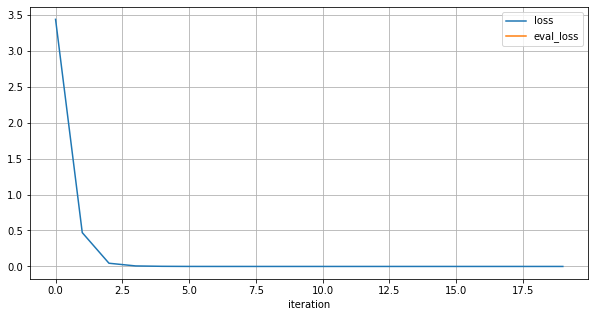

In [19]:
sql_training_info_model.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Step 4: Use the ML.EVALUATE function to evaluate the model data
The ML.EVALUATE function is used to evaluate model metrics. It reports the precision, recall, accuracy, f1_score, log_loss * roc_auc

Machine learning model evaluation metrics are used to

1. assess quality of fit between the model and the data,
2. compare different models, and
3. in the context of model selection, and to predict how accurate each model can be expected to perform on a specific data set.

Read the **BQML ML EVALUATE function** [doc](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate) reference

With the model created, you can now evaluate the linear regression model. Behind the scenes, BigQuery ML automatically <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#data_split_method" target="_blank">split the data</a>, which makes it easier to quickly train and evaluate models.


In [20]:
sql_evaluate_model = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME})
"""

print(sql_evaluate_model)

run_bq_query(sql_evaluate_model)


SELECT
  *
FROM
  ML.EVALUATE(MODEL bqml_linear_reg_worldbank_health_alcohol_consump_predict_model_dataset.bqml_linear_reg_worldbank_health_alcohol_consump_predict_model)

Finished job_id: ce37982c-7b30-4a6c-b295-738627e715d6


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,1.403180e-07,9.617119e-14,5.914426e-15,4.156949e-08,1.0,1.0


Another Query for getting evaluation metrics broken out by test, validate and training sets.


### **Commentary**:
When evaluating model metrics, a rule of thumb is, what does 0 mean, what does 1 mean?

#### **mean_absolute_error**:
MAE (Mean Absolute Error) is the average absolute error between actual and predicted values. [1](https://stephenallwright.com/good-mae-score/)

The lower the value the better and 0 means the model is perfect.

Absolute error, also known as **L1 loss**, is a row-level error calculation where the non-negative difference between the prediction and the actual is calculated. 

**MAE** is the aggregated mean of these errors, which helps us understand the model performance over the whole dataset.

*How its calculated* \
<img src="https://stephenallwright.com/content/images/2022/08/mae-definition-pink.png?ezimgfmt=rs:523x230/rscb1" width="300">

**mae** = mean_absolute_error(actual, predicted)

The closer MAE is to 0, the more accurate the model is. 

#### **mean_squared_error**: 
The lower the value the better and 0 means the model is perfect.

Mean Squared Error (MSE) is the average squared error between actual and predicted values.[2](https://stephenallwright.com/good-mse-value/)

Squared error, also known as **L2 loss**, is a row-level error calculation where the difference between the prediction and the actual is squared. MSE is the aggregated mean of these errors, which helps us understand the model performance over the whole dataset.

The main draw for using MSE is that it squares the error, which results in large errors being punished or clearly highlighted. It’s therefore useful when working on models where occasional large errors must be minimised.

<img src="https://stephenallwright.com/content/images/2022/08/mse-definition-blue.png?ezimgfmt=rs:523x230/rscb1" width="300">


#### **mean_squared_log_error**:
Mean Squared Log Error is the evaluation metrics that computes the ratio of predicted and actual values

The smaller the better. 

This is useful when dealing with right skewed targets, since taking the log transform makes the target more normally distributed. In practice it's usually achieved by changing the target to

##### **R2_score**:
R-Squared is a measure of fit where the value ranges from 1, where all variance is explained, to 0 where none of the variance is explained. The higher the R-Squared value the better. 

R-Squared is a metric for assessing the performance of regression machine learning models. Unlike other metrics, such as MAE or RMSE, it is not a measure of how accurate the predictions are, but instead a measure of fit. R-Squared measures how much of the dependent variable variation is explained by the independent variables in the model. [3](https://stephenallwright.com/good-r-squared-value/)


<img src="https://stephenallwright.com/content/images/2022/08/r-squared-definition.png?ezimgfmt=rs:523x230/rscb1" width="300">



##### **explained_variance**:
The number of principal components is selected such that the percentage of variance explained by the principal components is greater than the ratio specified by this argument.

The smaller the better. 

There are various metrics for Matrix Factorization and other model types (full list of metrics can be found in the <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate#mlevaluate_output" target="_blank">documentation</a>).

### Step 5: Use the ML.PREDICT function to predict the income bracket for a given set of census participants.

Finally, you use the [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict) function to predict the income bracket for a given set of census participants.

In [21]:
# Quick recap of the data we'll run predictions in our view data.

# We can examine the view data using the sql below.
sql_examine_view_data = f"""
SELECT * FROM {BQ_DATASET_NAME}.input_view  WHERE dataframe='prediction' limit 100;
"""

run_bq_query(sql_examine_view_data)

Finished job_id: d129923a-6dbd-45d0-96f1-0ebab72c08ec


,SH_ALC_PCAP_LI,short_name,currency_unit,income_group,national_accounts_base_year,system_of_trade,government_accounting_concept,country_name,country_code,SH_PRV_SMOK_FE,SH_STA_DIAB_ZS,SH_PRV_SMOK_MA,SH_PRV_SMOK,SH_ALC_PCAP_FE_LI,dataframe
0,13.210,Germany,Euro,High income,Original chained constant price data are resca...,Special trade system,Consolidated central government,Germany,DEU,22.850000,9.65,31.983333,24.983333,6.348,prediction
1,3.690,El Salvador,U.S. dollar,Lower middle income,Original chained constant price data are resca...,General trade system,Consolidated central government,El Salvador,SLV,3.066667,4.90,25.450000,14.266667,1.572,prediction
2,6.900,Malta,Euro,High income,Original chained constant price data are resca...,General trade system,Consolidated central government,Malta,MLT,23.366667,7.55,26.200000,27.383333,3.074,prediction
3,8.026,Iceland,Iceland krona,High income,Original chained constant price data are resca...,Special trade system,Consolidated central government,Iceland,ISL,11.050000,3.70,17.933333,15.083333,3.796,prediction
4,6.550,Belize,Belize dollar,Upper middle income,2000,General trade system,Budgetary central government,Belize,BLZ,NaN,13.45,NaN,NaN,2.722,prediction
5,NaN,Aruba,Aruban florin,High income,2013,General trade system,None,Aruba,ABW,NaN,10.90,NaN,NaN,NaN,prediction
6,1.666,Tunisia,Tunisian dinar,Lower middle income,2015,General trade system,Budgetary central government,Tunisia,TUN,3.100000,8.90,55.216667,25.250000,0.448,prediction
7,2.080,Oman,Omani rial,High income,2018,General trade system,Budgetary central government,Oman,OMN,0.850000,11.75,18.300000,9.566667,0.580,prediction
8,8.028,Burundi,Burundi franc,Low income,2005,General trade system,Budgetary central government,Burundi,BDI,7.900000,3.45,21.083333,12.333333,3.134,prediction
9,5.706,Sierra Leone,Sierra Leonean leone,Low income,2006,General trade system,Consolidated central government,Sierra Leone,SLE,9.883333,3.40,18.500000,19.783333,1.670,prediction


In [23]:
# We are using the remainder of our data ot perform predictions by limiting the dataframe to "PREDICTION".
sql_ml_predict = f"""
SELECT * FROM
 ML.PREDICT (MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME},
   (SELECT {MODEL_INPUT_COLUMNS},
    dataframe FROM {BQ_DATASET_NAME}.input_view
   WHERE dataframe = 'prediction')
 ) LIMIT 20
"""
print(sql_ml_predict)

run_bq_query(sql_ml_predict)


SELECT * FROM
 ML.PREDICT (MODEL bqml_linear_reg_worldbank_health_alcohol_consump_predict_model_dataset.bqml_linear_reg_worldbank_health_alcohol_consump_predict_model,
   (SELECT SH_ALC_PCAP_LI,short_name, currency_unit, income_group, national_accounts_base_year,system_of_trade, government_accounting_concept, country_name, country_code,SH_PRV_SMOK_FE, SH_STA_DIAB_ZS, SH_PRV_SMOK_MA, SH_PRV_SMOK, SH_ALC_PCAP_FE_LI,
    dataframe FROM bqml_linear_reg_worldbank_health_alcohol_consump_predict_model_dataset.input_view
   WHERE dataframe = 'prediction')
 ) LIMIT 20

Finished job_id: 9100c32f-b745-4085-b49d-5307dfbaeb2a


,predicted_SH_ALC_PCAP_LI,SH_ALC_PCAP_LI,short_name,currency_unit,income_group,national_accounts_base_year,system_of_trade,government_accounting_concept,country_name,country_code,SH_PRV_SMOK_FE,SH_STA_DIAB_ZS,SH_PRV_SMOK_MA,SH_PRV_SMOK,SH_ALC_PCAP_FE_LI,dataframe
0,7.378852,13.210,Germany,Euro,High income,Original chained constant price data are resca...,Special trade system,Consolidated central government,Germany,DEU,22.850000,9.65,31.983333,24.983333,6.348,prediction
1,3.804163,3.690,El Salvador,U.S. dollar,Lower middle income,Original chained constant price data are resca...,General trade system,Consolidated central government,El Salvador,SLV,3.066667,4.90,25.450000,14.266667,1.572,prediction
2,6.391553,6.900,Malta,Euro,High income,Original chained constant price data are resca...,General trade system,Consolidated central government,Malta,MLT,23.366667,7.55,26.200000,27.383333,3.074,prediction
3,5.098636,8.026,Iceland,Iceland krona,High income,Original chained constant price data are resca...,Special trade system,Consolidated central government,Iceland,ISL,11.050000,3.70,17.933333,15.083333,3.796,prediction
4,2.633992,6.550,Belize,Belize dollar,Upper middle income,2000,General trade system,Budgetary central government,Belize,BLZ,NaN,13.45,NaN,NaN,2.722,prediction
5,3.114358,NaN,Aruba,Aruban florin,High income,2013,General trade system,None,Aruba,ABW,NaN,10.90,NaN,NaN,NaN,prediction
6,1.488861,1.666,Tunisia,Tunisian dinar,Lower middle income,2015,General trade system,Budgetary central government,Tunisia,TUN,3.100000,8.90,55.216667,25.250000,0.448,prediction
7,2.575949,2.080,Oman,Omani rial,High income,2018,General trade system,Budgetary central government,Oman,OMN,0.850000,11.75,18.300000,9.566667,0.580,prediction
8,2.523388,8.028,Burundi,Burundi franc,Low income,2005,General trade system,Budgetary central government,Burundi,BDI,7.900000,3.45,21.083333,12.333333,3.134,prediction
9,2.805419,5.706,Sierra Leone,Sierra Leonean leone,Low income,2006,General trade system,Consolidated central government,Sierra Leone,SLE,9.883333,3.40,18.500000,19.783333,1.670,prediction



#### **Commentary**:
When the ML predict function runs, it generates 2 new columns. These are:
1. predicted_SH_ALC_PCAP_LI
1. predicted_SH_ALC_PCAP_LI_probs

The `predicted_SH_ALC_PCAP_LI` has the classfication predictions of the original `arrest` label.

The `predicted_SH_ALC_PCAP_LI_probs` contains the probability scores for each of the binary options.

Lets take a look at **row 3 **who's prediction results are as follows:
```
predicted_SH_ALC_PCAP_LI = False
predicted_SH_ALC_PCAP_LI_probs	=
{'label': True, 'prob': 0.07343320259354878}
{'label': False, 'prob': 0.9265667974064512}
arrest = false,
```
The model's arrest probability was 0.07% for True, and 92% for False based on the inputs provided. This matched the dataset original label.

```
date = 2009-04-19 01:30:00+00:00
block = 001XX W 105TH ST
primary_type = ROBBERY
description = ARMED: HANDGUN
location_description = STREET
domestic = false
beat = 512
district = 5
ward = 34
community_area = 49
fbi_code = 03
year = 2009

```


In [ ]:
print(MODEL_INPUT_COLUMNS)

### Step 6: Use the ML.EXPLAIN_PREDICT function to know which features are the most important to determine the weight

To understand why the model is generating these prediction results, you can use the ML.EXPLAIN_PREDICT function.


<a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict" target="_blank">ML.EXPLAIN_PREDICT</a> has built-in <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview" target="_blank">Explainable AI</a>. This allows you to see the top contributing features to each prediction and interpret how it was computed.

In [24]:
sql_explain_predict = f"""

SELECT * FROM
ML.EXPLAIN_PREDICT(MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME},
 (
  SELECT {MODEL_INPUT_COLUMNS},
  dataframe FROM {BQ_DATASET_NAME}.input_view
  WHERE dataframe = 'prediction'),
  STRUCT(3 as top_k_features)
 ) LIMIT 5
"""

run_bq_query(sql_explain_predict)

Finished job_id: 2b26502e-5de3-4d16-ba7a-9b015a07c5d8


,predicted_SH_ALC_PCAP_LI,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,SH_ALC_PCAP_LI,short_name,currency_unit,income_group,national_accounts_base_year,system_of_trade,government_accounting_concept,country_name,country_code,SH_PRV_SMOK_FE,SH_STA_DIAB_ZS,SH_PRV_SMOK_MA,SH_PRV_SMOK,SH_ALC_PCAP_FE_LI,dataframe
0,7.378852,"[{'feature': 'currency_unit', 'attribution': 1...",0.717188,7.378852,0.0,13.210,Germany,Euro,High income,Original chained constant price data are resca...,Special trade system,Consolidated central government,Germany,DEU,22.850000,9.65,31.983333,24.983333,6.348,prediction
1,3.804163,"[{'feature': 'national_accounts_base_year', 'a...",0.717188,3.804163,0.0,3.690,El Salvador,U.S. dollar,Lower middle income,Original chained constant price data are resca...,General trade system,Consolidated central government,El Salvador,SLV,3.066667,4.90,25.450000,14.266667,1.572,prediction
2,6.391553,"[{'feature': 'currency_unit', 'attribution': 1...",0.717188,6.391553,0.0,6.900,Malta,Euro,High income,Original chained constant price data are resca...,General trade system,Consolidated central government,Malta,MLT,23.366667,7.55,26.200000,27.383333,3.074,prediction
3,5.098636,"[{'feature': 'national_accounts_base_year', 'a...",0.717188,5.098636,0.0,8.026,Iceland,Iceland krona,High income,Original chained constant price data are resca...,Special trade system,Consolidated central government,Iceland,ISL,11.050000,3.70,17.933333,15.083333,3.796,prediction
4,2.633992,"[{'feature': 'income_group', 'attribution': 0....",0.717188,2.633992,0.0,6.550,Belize,Belize dollar,Upper middle income,2000,General trade system,Budgetary central government,Belize,BLZ,NaN,13.45,NaN,NaN,2.722,prediction



#### **Commentary**:
![AUC ROC](https://github.com/paulycloud/ml_portfolio/blob/main/02_BigQuery_ML/02_census_linear_reg/assets/ml_explain_predict.png?raw=true)

When the ML.EXPLAIN_PREDICT function runs, it generates 6 new columns. These are:
1. predicted_SH_ALC_PCAP_LI
1. probability
1. top_feature_attributions
1. baseline_prediction_value
1. prediction_value
1. approximation_error

Lets take a look at **row 3** who's prediction results are as follows:

```
predicted_SH_ALC_PCAP_LI = False
probability=0.937534
top_feature_attributions= ['block', 'location_description','description']
baseline_prediction_value=-0.09205144481628572
prediction_value=-1.5558649139933234
approximation_error=0.0

date = 2009-11-02 03:19:00+00:00
block = 0000X W 103RD PL
primary_type = CRIM SEXUAL ASSAULT
description = NON-AGGRAVATED
location_description = RESIDENCE-GARAGE
domestic = false
beat = 512
district = 5
ward = 34
community_area = 49
fbi_code = 02
year = 2009
```

The `predicted_SH_ALC_PCAP_LI` has the classfication predictions of the original `arrest` label. In this case, its False

The `probability` contains the probability scores for each of the binary options in this case its 93%.

The `top_feature_attributions` this is an array containing the 3 top features contributng to the prediction. In this case, Education_num, marital_status and age are the top factors.

The `baseline_prediction_value` is the mean across all numerical features and NULL for other types of features.

The `prediction_value` contains the probability scores for each of the binary options.

The `approximation_error` The exact attribution methods like Tree SHAP have the property such that baseline_prediction_value + {sigma} feature_attribution


### Step 7: Inspect the model on Vertex AI Model Registry

When the model was trained in BigQuery ML, the line `model_registry="vertex_ai"` registered the model to Vertex AI Model Registry automatically upon completion.

You can view the model on the <a href="https://console.cloud.google.com/vertex-ai/models" target="_blank">Vertex AI Model Registry page</a>, or use the code below to check that it was successfully registered:

In [ ]:
model = vertex_ai.Model(model_name=BQML_MODEL_NAME)
print(f'Review the Model in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{BQML_MODEL_NAME}?project={PROJECT_ID}')

print(model.gca_resource)



### Step 8: Create the endpoint and Deploy the model to an endpoint
Endpoints are machine learning models made available for online prediction requests. Endpoints are useful for timely predictions from many users (for example, in response to an application request). You can also request batch predictions if you don't need immediate results.

While BigQuery ML supports batch prediction with <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict" target="_blank">ML.PREDICT</a> and <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict" target="_blank">ML.EXPLAIN_PREDICT</a>, BigQuery ML is not suitable for real-time predictions where you need low latency predictions with potentially high frequency of requests.

In other words, deploying the BigQuery ML model to an endpoint enables you to do online predictions.


#### Create a Vertex AI endpoint
To deploy your model to an endpoint, you will first need to create an endpoint before you deploy the model to it.

In [ ]:
# create an endpoint if it doesn't exist
endpoints = vertex_ai.Endpoint.list(filter = f"display_name={BQML_ENDPOINT_NAME}")

if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].display_name}")
else:
    endpoint = vertex_ai.Endpoint.create(
    display_name=BQML_ENDPOINT_NAME,
    location=REGION,
    project=PROJECT_ID,
    )
    print(f"Endpoint Created: {endpoint.display_name}")

print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

print(endpoint.display_name)
print(endpoint.resource_name)

#### Deploy model to Vertex endpoint

With the new endpoint, you can now deploy your model.

In [ ]:
# deploying the model to the endpoint may take 10-15 minutes
model.deploy(endpoint=endpoint)

You can also check on the status of your model by visiting the <a href="https://console.cloud.google.com/vertex-ai/endpoints" target="_blank">Vertex AI Endpoints page</a>.

### Step 9: Make online predictions to the endpoint

Using a sample of the training data, you can test the endpoint to make online predictions.

In [ ]:
df_sample_requests_list = [
    {
      "date":"2009-04-19 01:30:00+00:00",
      "block":"106XX S WABASH AVE",
      "primary_type":"PUBLIC PEACE VIOLATION",
      "description":"RECKLESS CONDUCT",
      "location_description":"SIDEWALK",
      "domestic":"false",
      "beat":512,
      "district":5,
      "ward":34,
      "community_area":49,
      "fbi_code": "09",
      "year":2022,
    },
]

In [ ]:
prediction = endpoint.predict(df_sample_requests_list)
print(prediction)

You can then extract the predictions from the prediction response

In [ ]:
# to view the prediction for the first row
prediction.predictions[1]['prediction']

## Cleaning up

To clean up all Google Cloud resources used in this project, you can <a href="https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects" target="_blank">delete the Google Cloud
project</a> you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
# Undeploy model from endpoint and delete endpoint
endpoint.undeploy_all()
endpoint.delete()

# Delete BigQuery dataset, including the BigQuery ML model
#! bq rm -r -f $PROJECT_ID:$BQ_DATASET_NAME